# Plots for Computation of random time-shift distributions for stochastic population models

This notebook produces all the plots featured in our paper "Computation of random time-shift distributions for stochastic population models". The data must first be produced and in the results directory for this to run appropriately. 

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from scipy.integrate import solve_ivp

rc_fonts = {
    "font.family": "serif",
    "font.size": 10,
    "text.usetex": True,
}
mpl.rcParams.update(rc_fonts)
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['lines.linewidth'] = 0.75
sns.set_palette('Set2')
%matplotlib inline

# Useful for running matplotlib on high-dpi displays
%config InlineBackend.figure_format = 'retina'

figures_dir = "./examples/figures/"


## SIR plots

In [33]:
results_dir = "./examples/results/SIR/"

In [34]:
df_stoch = pd.read_csv(results_dir + "stoch_samples.csv")
df_det = pd.read_csv(results_dir + "det_samples.csv")
df_peaks = pd.read_csv(results_dir + "peak_timings.csv")


In [35]:
df_pdf_vals = pd.read_csv(results_dir + "pdf_vals.csv")

In [36]:
t_prime = 20
delta_t = 0.1
t_range_lin = np.arange(-10, t_prime + 5 + delta_t, delta_t)

pars = [1.9, 2.0]
R0, gamma_inv = pars
gamma = 1 / gamma_inv
beta = R0 * gamma
r = beta - gamma


def model(t, y, pars):
    R0, gamma_inv = pars
    gamma = 1 / gamma_inv
    beta = R0 * gamma

    s, i = y
    dydt = np.array([-beta * i * s, beta * i * s - gamma * i])
    return dydt


K = int(10**6)
Z0 = np.array([K - 1, 1, 0], dtype=np.int64)

# initial condition
y0 = Z0[:2] / K

# time points
obs_t = 80
t = np.linspace(0, obs_t, num=10**6)

# solve ODE
sol = solve_ivp(lambda t, y: model(t, y, pars), (0, obs_t), y0, t_eval=t)

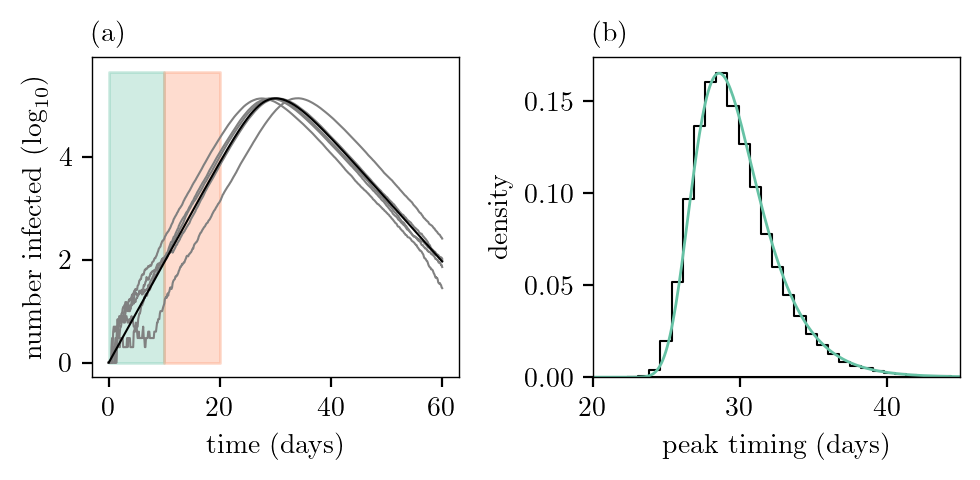

In [37]:
# sns.set_palette('colorblind')

fig, axs = plt.subplots(1, 2, figsize=(5.0, 2.5))
# fig, axs = plt.subplots(1, 2)

t_obs = 60
t_keep = df_stoch["t"] <= t_obs

for col in df_stoch:
    if col != "t":
        axs[0].plot(
            df_stoch["t"][t_keep],
            np.log10(df_stoch[col][t_keep]),
            color="grey",
            # alpha=0.75,
        )

axs[0].plot(df_det["t"][t_keep], np.log10(df_det["I"])[t_keep], color="black")
axs[0].set_xlabel("time (days)")
axs[0].set_ylabel("number infected " + r"$(\log_{10})$")
axs[0].fill_between(
    [0, 10],
    0.9 * min(np.log10(df_det["I"])[t_keep]),
    1.1 * max(np.log10(df_det["I"])[t_keep]),
    alpha=0.3,
    zorder=0,
    color="C0",
)
axs[0].fill_between(
    [10, 20],
    0.9 * min(np.log10(df_det["I"])[t_keep]),
    1.1 * max(np.log10(df_det["I"])[t_keep]),
    alpha=0.3,
    zorder=0,
    color="C1",
)

sns.histplot(
    df_peaks["peak_timings"],
    stat="density",
    bins=40,
    ax=axs[1],
    shrink=True,
    alpha=0,
    ec="black",
    element="step",
    lw=0.75,
)

# Overlay the estimated PDF + add the extra bit for estimating the distribution of the peak
axs[1].plot(
    -df_pdf_vals["t"] + sol.t[np.argmax(sol.y[1])],
    df_pdf_vals["pdf"],
    color="C0",
    lw=1.0,
)
# sns.kdeplot(df_peaks['peak_timings'], ax=axs[1], color='#4c9be3')
axs[1].set_xlim((20, 45))
axs[1].set_xlabel("peak timing (days)")
axs[1].set_ylabel("density")

axs[0].set_title(r"(a)", loc="left", fontsize=10)
axs[1].set_title(r"(b)", loc="left", fontsize=10)

fig.tight_layout()
plt.savefig(figures_dir + "Figure1.pgf", dpi=300, bbox_inches="tight")


In [38]:
df_tau_mapping = pd.read_csv(results_dir + "tau_mapping.csv")
df_tau_log_state_dist = pd.read_csv(results_dir + "tau_log_state.csv")
df_pdf_vals = pd.read_csv(results_dir + "pdf_vals.csv")

In [39]:
t_prime = 20
delta_t = 0.1
t_range_lin = np.arange(-10, t_prime + 5 + delta_t, delta_t)

pars = [1.9, 2.0]
R0, gamma_inv = pars
gamma = 1 / gamma_inv
beta = R0 * gamma
r = beta - gamma


In [40]:
df_phi = pd.read_csv(results_dir + "phi_vals.csv")


Text(0, 0.5, '$\\phi(\\theta)$')

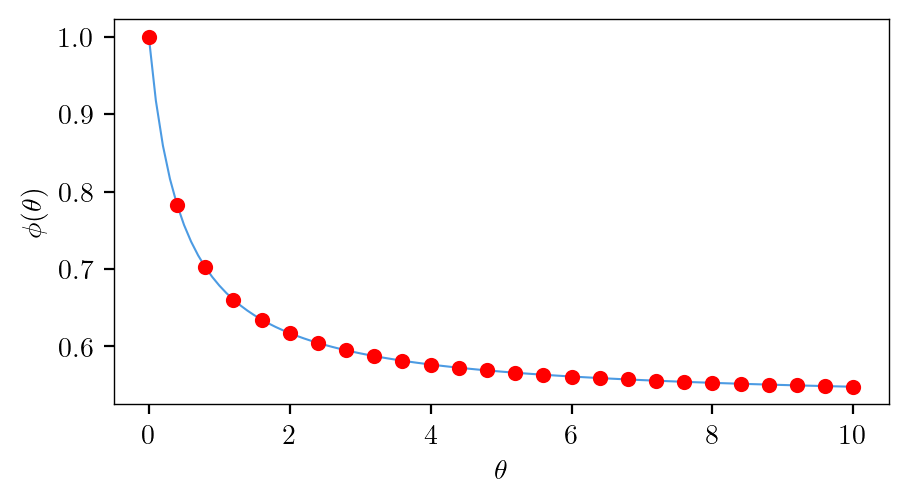

In [41]:
fig, ax = plt.subplots(figsize=(5.0, 2.5))

s_range = np.arange(0, 10 + 0.1, 0.1)


def phi(s, beta, gamma):
    return gamma / beta + ((beta - gamma) / beta) / (1 + beta * s / (beta - gamma))


ax.scatter(s_range[0::4], df_phi.phi[0::4], c="red", zorder=3, s=20)
ax.plot(s_range, phi(s_range, beta, gamma), c="#4c9be3", zorder=2)

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\phi(\theta)$")


In [42]:
def log_det_linear(x, y, t, r):
    c = y - x * r
    return r * t + c


In [43]:
q = 2.5
x = df_tau_mapping.loc[df_tau_mapping["type"] == "proj_" + str(q), "x0"][0]
y = df_tau_mapping.loc[df_tau_mapping["type"] == "proj_" + str(q), "y0"][0]

t_lin = t_range_lin[t_range_lin <= 20]
y_lin = log_det_linear(x, y, t_range_lin, r)


/var/folders/0f/zvtb3k3j49n36j2gc61mt2br0000gn/T/ipykernel_55622/1234304016.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


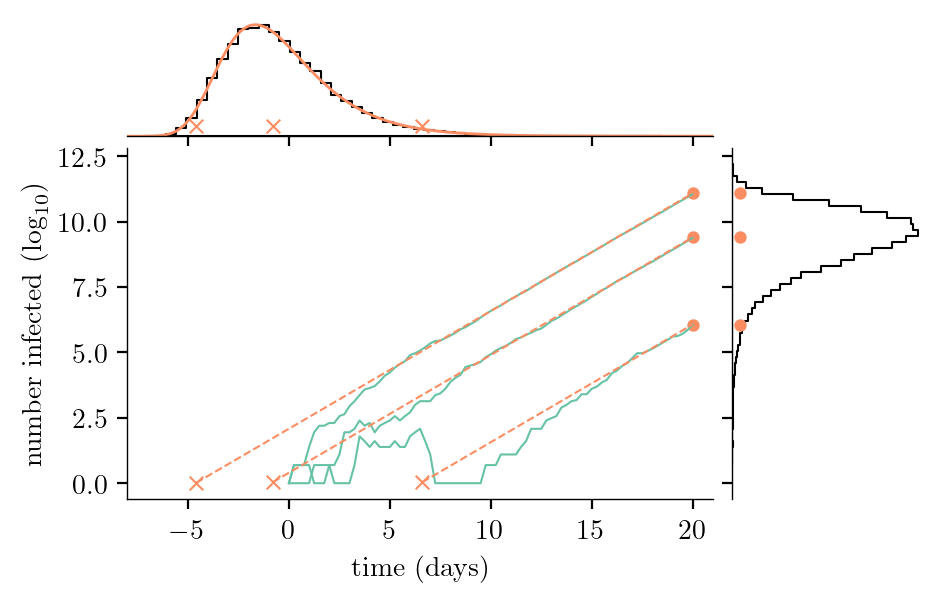

In [44]:
# fig, axs = plt.subplots(2, 2, figsize=(5.5, 3.5))
fig = plt.figure(figsize=(5.0, 3))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(
    2,
    2,
    width_ratios=(3, 1),
    height_ratios=(1, 3),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.05,
)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
quantiles = [2.5, 50.0, 97.5]

for i, q in enumerate(quantiles):
    x = df_tau_mapping.loc[df_tau_mapping["type"] == str(q), "t"].iloc[0::25]
    y = df_tau_mapping.loc[df_tau_mapping["type"] == str(q), "y"].iloc[0::25]

    # ax.step(x[x <= 20], y[x <= 20], color='C0')
    ax.plot(x[x <= 20], y[x <= 20], color="C0")

sns.histplot(
    df_tau_log_state_dist["tau"],
    stat="density",
    bins=50,
    ax=ax_histx,
    alpha=0,
    ec="black",
    shrink=True,
    element="step",
    lw=0.75,
)
sns.histplot(
    y=df_tau_log_state_dist["y"],
    stat="density",
    bins=50,
    ax=ax_histy,
    alpha=0,
    ec="black",
    shrink=True,
    element="step",
    lw=0.75,
)
# Overlay the estimated PDF
ax_histx.plot(-df_pdf_vals["t"], df_pdf_vals["pdf"], color="C1", lw=1.0)

for q in quantiles:
    x = df_tau_mapping.loc[df_tau_mapping["type"]
                           == "proj_" + str(q), "x0"].iloc[0]
    y = df_tau_mapping.loc[df_tau_mapping["type"]
                           == "proj_" + str(q), "y0"].iloc[0]

    t_lin = t_range_lin[t_range_lin <= 20]
    y_lin = log_det_linear(x, y, t_lin, r)
    idx = np.searchsorted(y_lin > 0, 1)
    ax.plot(t_lin[y_lin >= 0], y_lin[y_lin >= 0], ls="--", color="C1", lw=0.75)
    ax.scatter(t_lin[idx], y_lin[idx], s=24, color="C1", marker="x")
    ax_histx.scatter(t_lin[idx], 0.015, s=24, color="C1", marker="x")

    ax.scatter(20, log_det_linear(x, y, 20, r), s=12, color="C1")
    ax_histy.scatter(0.015, log_det_linear(x, y, 20, r), s=12, color="C1")


ax.spines[["top", "right"]].set_visible(False)
ax_histx.spines[["top", "left", "right"]].set_visible(False)
ax_histy.spines[["top", "bottom", "right"]].set_visible(False)
ax_histx.set_xlabel(None)
ax_histx.set_ylabel(None)
ax_histy.set_xlabel(None)
ax_histy.set_ylabel(None)

ax_histx.xaxis.set_tick_params(labelbottom=False, bottom=True)
ax_histx.yaxis.set_tick_params(labelbottom=False, bottom=False)
ax_histy.xaxis.set_tick_params(labelleft=False, bottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False, bottom=True)

ax.set_xlim(-8, t_prime + 1)
ax.set_ylabel("number infected " + r"$(\log_{10})$")
ax.set_xlabel("time (days)")
fig.tight_layout()
fig.savefig(figures_dir + "Figure2.pgf", dpi=300, bbox_inches="tight")


## SEIR plots

In [45]:
results_dir = "./examples/results/SEIR/"

In [46]:
ids = range(6)

df_times = pd.read_csv(results_dir + "time_delays_control.csv")
df_pdf = [
    pd.read_csv(results_dir + "pdf_vals_moments_" + str(id + 1) + ".csv") for id in ids
]

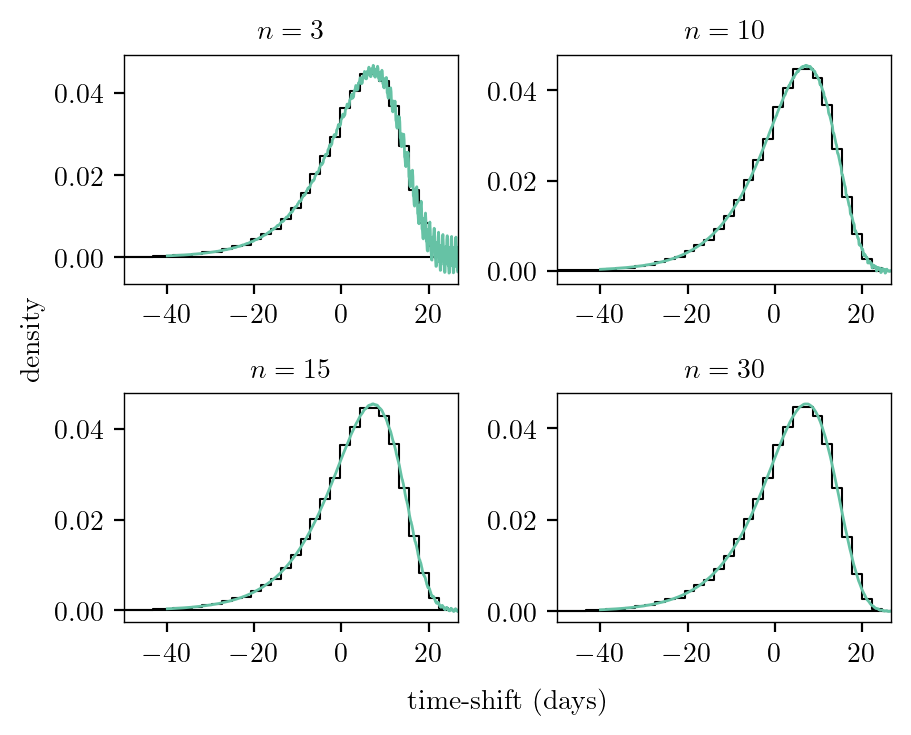

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.0, 4.0))

num_moment_vals = [3, 5, 10, 30]
num_moment_vals_all = [3, 5, 10, 15, 30, 60]
num_moment_vals_keep = [5, 60]
title_labels = ["a", "b", "c", "d"]

row, col = 0, 0
for id in ids:
    if num_moment_vals_all[id] not in num_moment_vals_keep:
        ax = axs[row, col]

        ax.plot(
            df_pdf[id]["t"],
            df_pdf[id]["pdf"],
            zorder=2,
            label=r"${}$".format(num_moment_vals_all[id]),
            lw=1,
        )

        sns.histplot(
            data=df_times.loc[df_times.method == "approx"],
            x="time_delay",
            ax=ax,
            stat="density",
            zorder=0,
            bins=50,
            alpha=0,
            shrink=True,
            element="step",
            ec="black",
            lw=0.75,
        )

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xlim(-50, df_times.loc[df_times.method == "approx", "time_delay"].max())
        # ax.set_title(r"({})".format(title_labels[n]), loc="left", fontsize=10)
        ax.set_title(r"$n = {}$".format(num_moment_vals_all[id]), fontsize=10)

        col += 1
        if col == 2:
            row += 1
            col = 0


fig.tight_layout()
ax0 = fig.add_subplot(111, frame_on=False)  # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylabel(r"density", labelpad=25)
ax0.set_xlabel(r"time-shift (days)", labelpad=20)
# fig.supxlabel(r'time-shift (days)')
# fig.supylabel()
fig.tight_layout()

fig.savefig(
    figures_dir + "n_dists_tails.pdf", dpi=300, format="pdf", bbox_inches="tight"
)
fig.savefig(figures_dir + "Figure3.pgf", dpi=300, bbox_inches="tight")

In [48]:
ids = range(4)
df_times = pd.read_csv(results_dir + "time_delays_control.csv")
df_pdf = [pd.read_csv(results_dir + "pdf_vals_h_" +
                      str(id + 1) + ".csv") for id in ids]


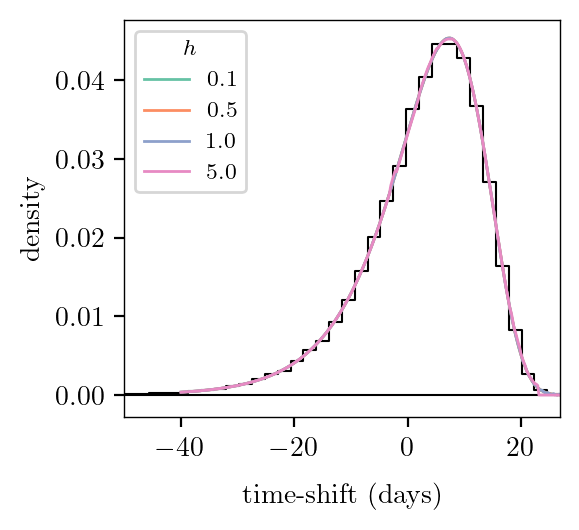

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.0, 2.75))

h_vals = [0.1, 0.5, 1.0, 5.0]
h_vals_all = [0.1, 0.5, 1.0, 5.0, 10.0, 20.0]

for id in ids:
    if h_vals_all[id] not in [10, 20]:
        ax.plot(
            df_pdf[id]["t"],
            df_pdf[id]["pdf"],
            zorder=2,
            label=r"${}$".format(h_vals_all[id]),
            lw=1,
        )


sns.histplot(
    data=df_times.loc[df_times.method == "approx"],
    x="time_delay",
    ax=ax,
    stat="density",
    zorder=0,
    bins=50,
    alpha=0,
    shrink=True,
    element="step",
    ec="black",
    lw=0.75,
)

ax.legend(title=r"$h$", fontsize=8, title_fontsize=8)

ax.set_xlabel("")
ax.set_ylabel(r"density")
ax.set_xlim(-50, df_times.loc[df_times.method == "approx", "time_delay"].max())
# ax.set_ylim(0.825, 1.025)
# ax.set_title(r"(b)", loc="left", fontsize=10)

fig.tight_layout()
ax0 = fig.add_subplot(111, frame_on=False)  # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
# ax0.set_ylabel(r'cumulative probability', labelpad=25)
ax0.set_xlabel(r"time-shift (days)", labelpad=20)
# fig.supxlabel(r'time-shift (days)')
# fig.supylabel()
fig.tight_layout()

fig.savefig(
    figures_dir + "h_dists_tails.pdf", dpi=300, format="pdf", bbox_inches="tight"
)
fig.savefig(figures_dir + "Figure4.pgf", dpi=300, bbox_inches="tight")

In [50]:
ids = range(4)
df_times = [
    pd.read_csv(results_dir + "time_delays_Z0_" + str(id + 1) + ".csv") for id in ids
]
df_pdf = [
    pd.read_csv(results_dir + "pdf_vals_Z0_" + str(id + 1) + ".csv") for id in ids
]
# df_pars_m3 = [pd.read_csv(results_dir + 'pars_m3_' + str(id + 1) + '.csv') for id in ids]


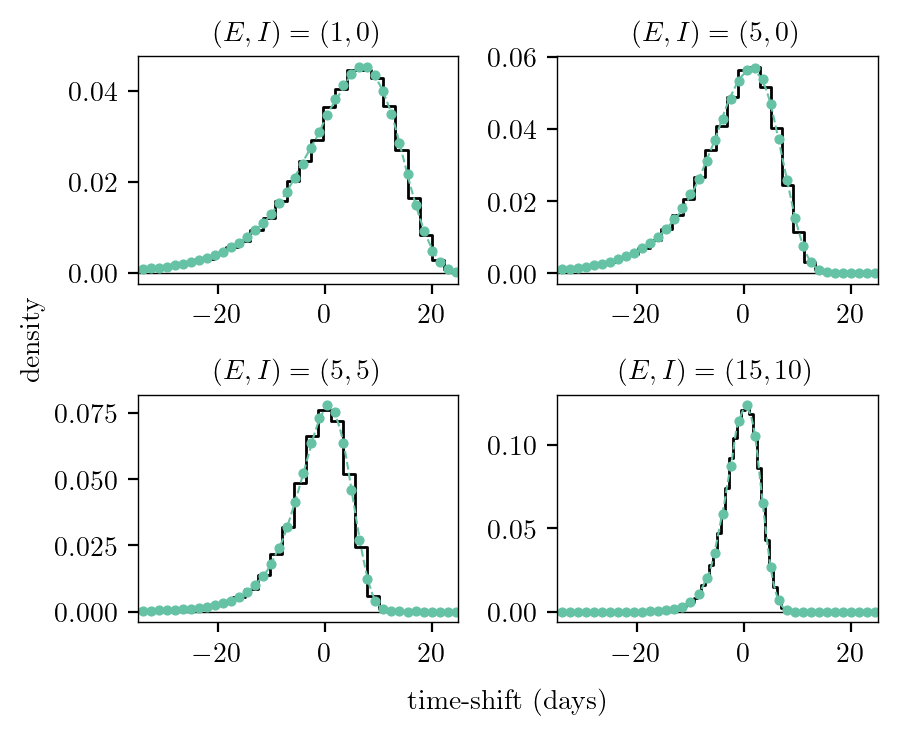

In [51]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.0, 4.0))

E0_v = [1, 5, 5, 15]
I0_v = [0, 0, 5, 10]

row, col = 0, 0
max_t = 0.0
for id in ids:
    ax = axs[row, col]
    sns.histplot(
        data=df_times[id].loc[df_times[id].method == "approx"],
        x="time_delay",
        ax=ax,
        stat="density",
        zorder=0,
        bins=50,
        alpha=0,
        shrink=True,
        element="step",
        ec="black",
    )
    sns.kdeplot(
        data=df_times[id].loc[df_times[id].method == "m3"],
        x="time_delay",
        ax=ax,
        zorder=2,
        lw=0.75,
        ls="dashed",
        c="C0",
    )
    #  label = r'({},{})'.format(E0_v[id], I0_v[id]))

    ax.axhline(0, c="white", zorder=1, lw=1.5)
    ax.axhline(0, c="black", zorder=1, lw=0.5)
    ax.scatter(
        df_pdf[id]["t"][::15], df_pdf[id]["p"][::15], lw=0.5, zorder=2, s=10, c="C0"
    )

    ax.set_xlim(-35, 25)
    ax.set_title(r"$(E, I) = ({}, {})$".format(
        E0_v[id], I0_v[id]), fontsize=10)
    # ax.set_xlabel(r'time-shift (days)')
    # ax.set_ylabel(r'density')
    ax.set_xlabel(r"")
    ax.set_ylabel(r"")

    col += 1
    if col == 2:
        row += 1
        col = 0

# ax.set_xlim(-35, 25)
# ax.legend(title=r'$(E, I)$')
# ax.set_xlabel(r'time-shift (days)')
# ax.set_ylabel(r'density')

fig.tight_layout()
ax0 = fig.add_subplot(111, frame_on=False)  # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
# ax0.set_ylabel(r'cumulative probability', labelpad=25)
ax0.set_xlabel(r"time-shift (days)", labelpad=20)
ax0.set_ylabel(r"density", labelpad=30)

fig.tight_layout()

fig.savefig(figures_dir + "Z0_dists.pdf", dpi=300,
            format="pdf", bbox_inches="tight")
fig.savefig(figures_dir + "Figure5.pgf", dpi=300, bbox_inches="tight")


In [52]:
ids = range(4)
df_times = [
    pd.read_csv(results_dir + "time_delays_N_" + str(id + 1) + ".csv") for id in ids
]
df_pdf = [pd.read_csv(results_dir + "pdf_vals_N_" +
                      str(id + 1) + ".csv") for id in ids]


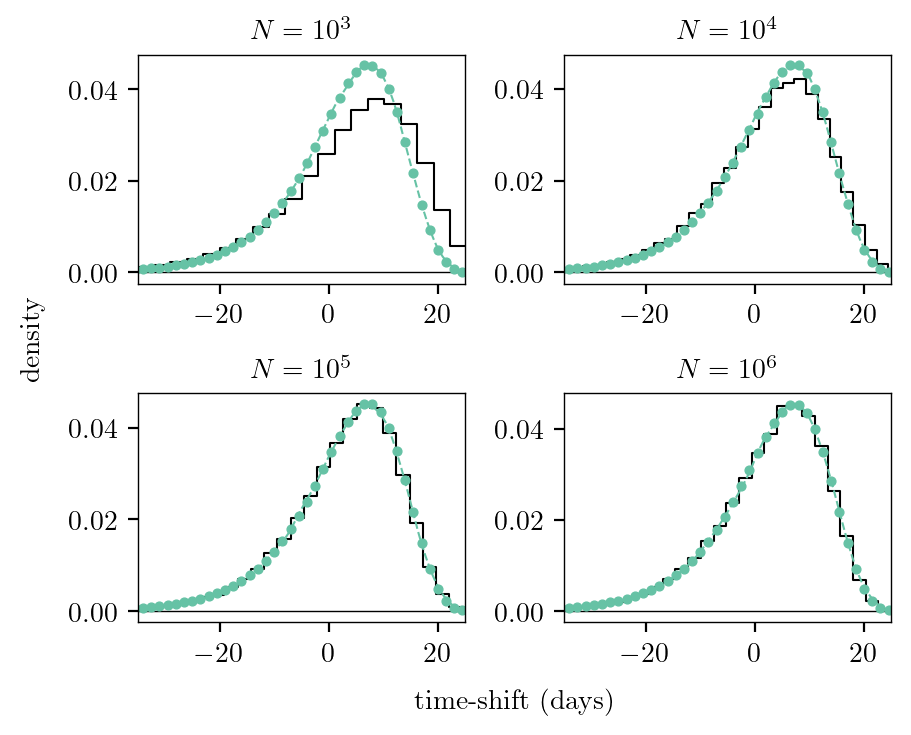

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.0, 4.0))

Ks = [10**x for x in range(3, 7)]

max_t = 0.0
row, col = 0, 0
for id in ids:
    ax = axs[row, col]

    sns.histplot(
        data=df_times[id].loc[df_times[id].method == "approx"],
        x="time_delay",
        ax=ax,
        stat="density",
        zorder=0,
        bins=50,
        alpha=0,
        shrink=True,
        element="step",
        lw=0.75,
        ec="black",
    )
    sns.kdeplot(
        data=df_times[id].loc[df_times[id].method == "m3"],
        x="time_delay",
        ax=ax,
        zorder=2,
        lw=0.75,
        ls="dashed",
        c="C0",
    )
    ax.scatter(
        df_pdf[id]["t"][::15], df_pdf[id]["p"][::15], lw=0.5, zorder=2, s=10, c="C0"
    )

    ax.axhline(0, c="white", zorder=1, lw=1.5)
    ax.axhline(0, c="black", zorder=1, lw=0.5)

    ax.set_xlim(-35, 25)
    # ax.set_title(r"$K = 10^{}$".format(Ks[id]), fontsize=10)
    ax.set_title(r"$N = 10^{}$".format(int(math.log10(Ks[id]))), fontsize=10)
    ax.set_xlabel(r"")
    ax.set_ylabel(r"")

    col += 1
    if col == 2:
        row += 1
        col = 0


fig.tight_layout()
ax0 = fig.add_subplot(111, frame_on=False)  # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylabel(r"density", labelpad=30)
ax0.set_xlabel(r"time-shift (days)", labelpad=20)
fig.tight_layout()

fig.savefig(figures_dir + "N_dists.pdf", dpi=300,
            format="pdf", bbox_inches="tight")
fig.savefig(figures_dir + "Figure6.pgf", dpi=300, bbox_inches="tight")


## TCL plots

In [3]:
results_dir = "./examples/results/TCL_receptor/"

In [4]:
df_times = pd.read_csv(results_dir + "time_delays.csv")
df_pdf = pd.read_csv(results_dir + "pdf_vals.csv")
df_pdf_div = pd.read_csv(results_dir + "pdf_vals_divergent.csv")
df_stoch_all_states = pd.read_csv(results_dir + "stoch_all_states.csv")
df_det_all_states = pd.read_csv(results_dir + "det_all_states.csv")


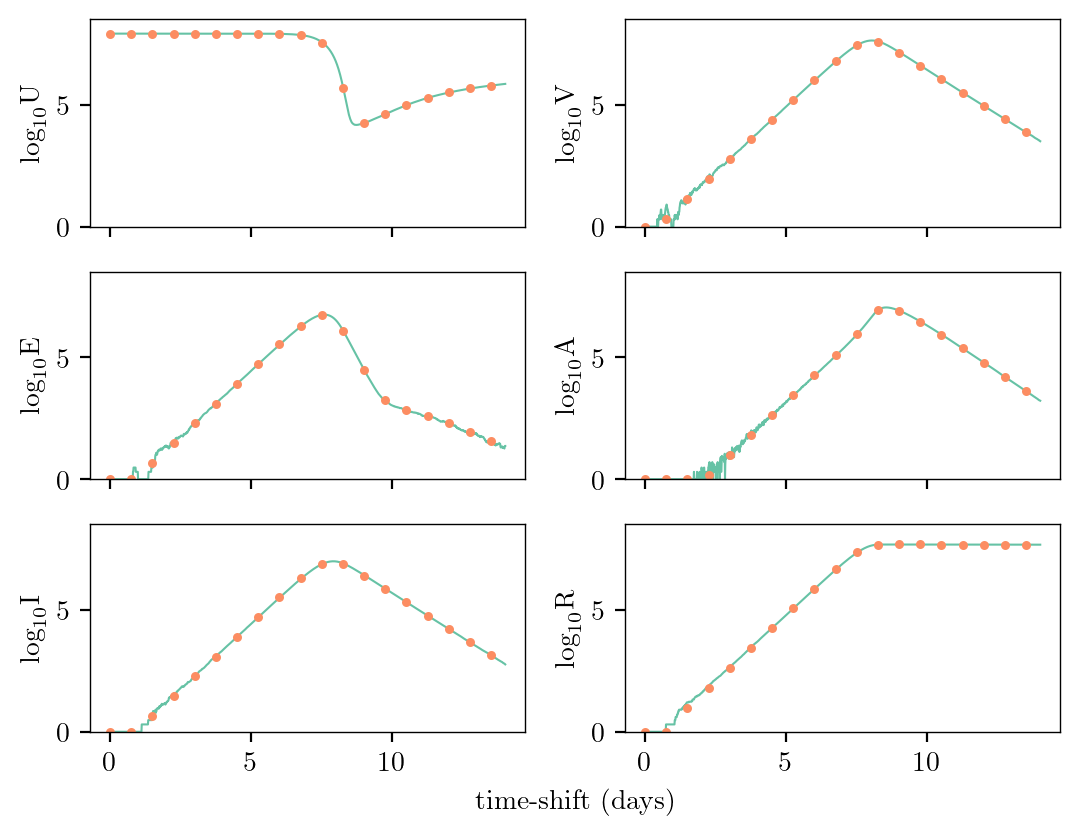

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(5.5, 4.5), sharex=True)

state_vars = ["U", "E", "I", "V", "A", "R"]

row = 0
col = 0
for i, v in enumerate(state_vars):
    axs[row][col].plot(
        df_stoch_all_states["time"],
        np.maximum(0, np.log10(df_stoch_all_states[v])),
        c="C0",
        zorder=1,
    )
    axs[row][col].scatter(
        df_det_all_states["time"][::75],
        np.maximum(0, np.log10(df_det_all_states[v][::75])),
        c="C1",
        s=5,
        zorder=2,
    )
    # axs[row][col].plot(df_det_all_states['time'], np.maximum(0, np.log(df_det_all_states[v])),
    #                    c = 'C1', zorder = 2, ls = 'dashed')

    axs[row][col].set_ylim(0, 8.5)
    axs[row][col].set_ylabel(r"$\log_{10}$%s" % (v))
    row += 1
    if row == 3:
        row = 0
        col += 1

ax0 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
plt.xlabel(r"time (days)")
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel(r"time-shift (days)", labelpad=20)
fig.tight_layout()

fig.savefig(figures_dir + "TCLIR_example_sim.pdf",
            dpi=300, bbox_inches="tight")
fig.savefig(figures_dir + "Figure7.pgf", bbox_inches="tight")


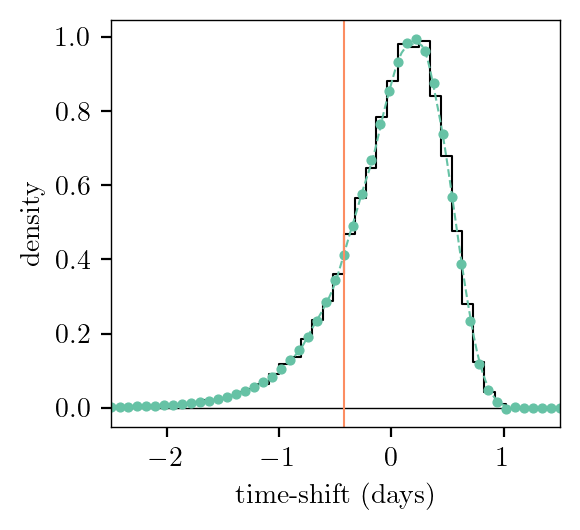

In [57]:
fig, ax = plt.subplots(figsize=(3.0, 2.75))
sns.histplot(
    data=df_times.loc[df_times.method == "approx"],
    x="time_delay",
    ax=ax,
    stat="density",
    zorder=0,
    bins=50,
    alpha=0,
    shrink=True,
    element="step",
    lw=0.75,
    ec="black",
    label=r"({},{})".format(E0_v, I0_v),
)
sns.kdeplot(
    data=df_times.loc[df_times.method == "approx"],
    x="time_delay",
    ax=ax,
    zorder=2,
    lw=0.75,
    ls="dashed",
    c="C0",
)
ax.scatter(df_pdf["t"][::80], df_pdf["p"][::80],
           lw=0.5, zorder=2, s=10, c="C0")
ax.axvline(-0.4218299999999999, c="C1")
ax.axhline(0, c="white", zorder=1, lw=1.5)
ax.axhline(0, c="black", zorder=1, lw=0.5)

ax.set_xlim(-2.5, 1.5)
# ax.legend(title=r'$(E, I)$')
ax.set_xlabel(r"time-shift (days)")
ax.set_ylabel(r"density")

fig.tight_layout()

# fig.savefig(figures_dir + 'time_shift_TCLIR.pdf', dpi=300, format='pdf', bbox_inches='tight')
fig.savefig(figures_dir + "time_shift_TCLIR.pdf",
            format="pdf", bbox_inches="tight")
fig.savefig(figures_dir + "Figure8.pgf", bbox_inches="tight")


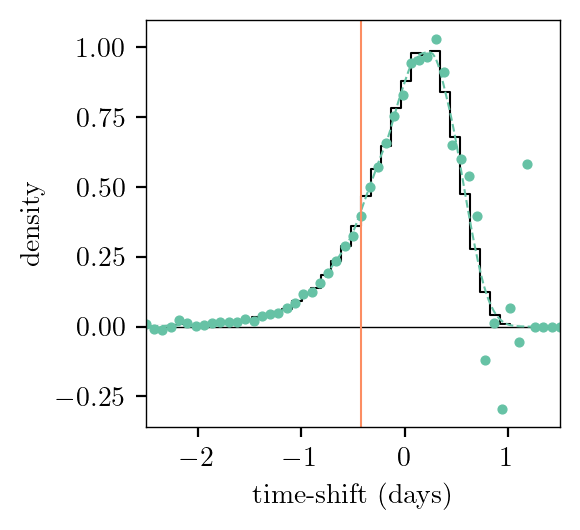

In [58]:
fig, ax = plt.subplots(figsize=(3.0, 2.75))
sns.histplot(
    data=df_times.loc[df_times.method == "approx"],
    x="time_delay",
    ax=ax,
    stat="density",
    zorder=0,
    bins=50,
    alpha=0,
    shrink=True,
    element="step",
    lw=0.75,
    ec="black",
    label=r"({},{})".format(E0_v, I0_v),
)
sns.kdeplot(
    data=df_times.loc[df_times.method == "approx"],
    x="time_delay",
    ax=ax,
    zorder=2,
    lw=0.75,
    ls="dashed",
    c="C0",
)
ax.scatter(df_pdf_div["t"][::80], df_pdf_div["p"]
           [::80], lw=0.5, zorder=2, s=10, c="C0")
ax.axvline(-0.4218299999999999, c="C1")
ax.axhline(0, c="white", zorder=1, lw=1.5)
ax.axhline(0, c="black", zorder=1, lw=0.5)

ax.set_xlim(-2.5, 1.5)
# ax.legend(title=r'$(E, I)$')
ax.set_xlabel(r"time-shift (days)")
ax.set_ylabel(r"density")

fig.tight_layout()

# fig.savefig(figures_dir + 'time_shift_TCLIR.pdf', dpi=300, format='pdf', bbox_inches='tight')
fig.savefig(figures_dir + "time_shift_TCLIR_div.pdf",
            format="pdf", bbox_inches="tight")
fig.savefig(figures_dir + "Figure9.pgf", bbox_inches="tight")
